목차

1. 데이터, 가설, 평가지표 소개
2. 기준모델
3. 딥러닝 적용 
-모델 구성법
-모델1.Simple RNN
-모델2.LSTM
-모델3.GRU
4. Transfer Learning
-Sorce Model
-LSTM (학습x)
-LSTM (학습 1층)
-LSTM (학습 2층)
5. 결론
6. 향후 보완하고 싶은 점 , 후속 프로젝트





In [13]:
#라이브러리 

!pip install category_encoders
!pip install finance-datareader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import FinanceDataReader as fdr
import tensorflow as tf

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Conv1D, Lambda, Dropout
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, Huber
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint    

     |████████████████████████████████| 82 kB 350 kB/s 


In [2]:
from os import chdir as cd

In [7]:
from google.colab import files
uploaded= files.upload()

Saving features_rev.csv to features_rev.csv
Saving train_rev.csv to train_rev.csv


In [5]:
#google drive mount

#cd /content/drive/MyDrive/CodeStates/Section2/dataset/walmart-recruiting-store-sales-forecasting

NameError: ignored

In [97]:
#데이터 불러오기 
import pandas as pd
train_rev=pd.read_csv("train_rev.csv",index_col="Date")
features_rev=pd.read_csv("features_rev.csv",index_col="Date")
#데이터 합치고, column수정하기 
df=train_rev.merge(features_rev,on="Date",how="inner")
cols=df.columns

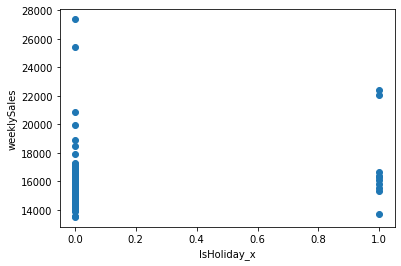

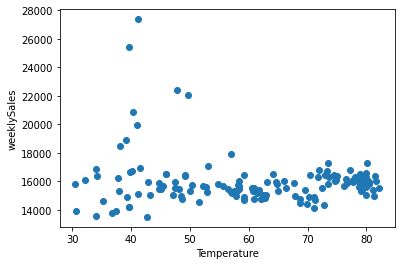

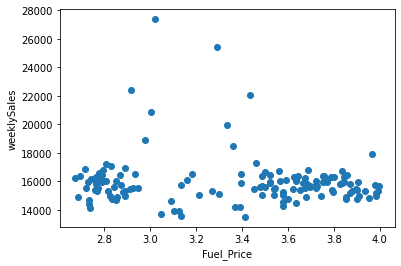

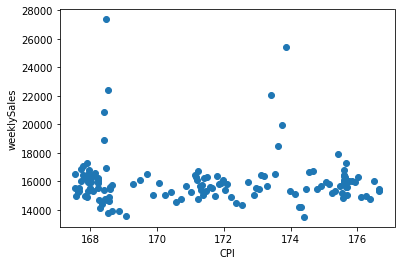

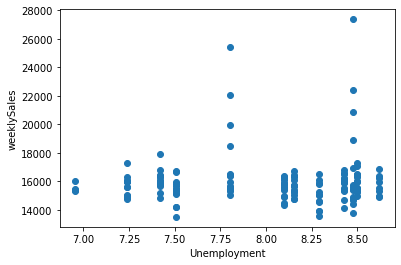

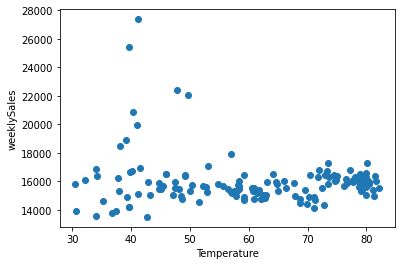

In [33]:
#weekly sales 에 관련한 특성 분포 보여주기 
def scatter(df, column):
    plt.figure()
    plt.scatter(df[column] , df['Weekly_Sales'])
    plt.ylabel('weeklySales')
    plt.xlabel(column)

scatter(df,'IsHoliday_x')
scatter(df,'Temperature')
scatter(df, 'Fuel_Price')
scatter(df, 'CPI')
scatter(df, 'Unemployment')
scatter(df, 'Temperature')

머신러닝 (기준모델)

In [104]:
#train data set 나누기 

train,test=train_test_split(df,test_size=0.16,shuffle=False)

#X,y 데이터 분리 
target='Weekly_Sales'

y_train=train[target]
X_train=train.drop(target,axis=1)
y_test=test[target]
X_test=test.drop(target,axis=1)

In [35]:
def pred_plot(preds):
  actual_pred = pd.DataFrame(columns = ['Weekly_Sales', 'prediction'])
  actual_pred['Weekly_Sales']=df.Weekly_Sales.iloc[120:][0:len(preds)]
  actual_pred['prediction']=preds
  y_true = actual_pred['Weekly_Sales']
  y_pred = actual_pred['prediction']

  print(y_true[:2])
  print(y_pred[:2])
  print("len comp(true vs pred):",len(y_true),len(y_pred))
  mae = MeanAbsoluteError()
  mse = MeanSquaredError()
  result=mae(y_true,y_pred).numpy()
  result2=mse(y_true,y_pred).numpy()
  return print("mae:",result,"mse:",result2,actual_pred.plot())

In [36]:
#XGB BOOST regressor (random forest)
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBRegressor(max_depth=10)
)

pipe.fit(X_train, y_train);
y_train_pred=pipe.predict(X_train)
y_test_pred=pipe.predict(X_test)

print("훈련데이터")
print("MAE:",mean_absolute_error(y_train,y_train_pred),"MSE:",mean_squared_error(y_train,y_train_pred),"R2:",r2_score(y_train,y_train_pred))

print("테스트데이터")
print("MAE:",mean_absolute_error(y_test,y_test_pred),"MSE:",mean_squared_error(y_test,y_test_pred),"R2:",r2_score(y_test,y_test_pred))

[03:03:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
훈련데이터
MAE: 16.016836304582238 MSE: 857.9631462566424 R2: 0.9997678703856969
테스트데이터
MAE: 1130.883935943375 MSE: 1993831.0106385113 R2: -4.4295455497450416


Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15330.041016
2012-06-01    17001.974609
Name: prediction, dtype: float32
len comp(true vs pred): 23 23
mae: 1130.884 mse: 1993831.2 AxesSubplot(0.125,0.125;0.775x0.755)


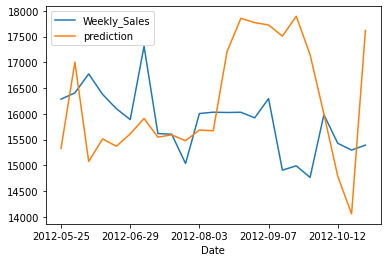

In [37]:
pred_plot(y_test_pred)

Deep Learning (RNN, LSTM, GRU)

핵심은 트레인, 테스트 셋

In [136]:
def WindowGenerator_normalize(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data BY 120
      X_test:  data from 120:
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = train_rev.iloc[:120,:1].values
    ts_test  = train_rev.iloc[120:,:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data (추가) train data만 가지고 transform - 매우중요
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling - 
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((train_rev["Weekly_Sales"].iloc[:120], train_rev["Weekly_Sales"].iloc[120:]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

        # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [179]:
X_train, y_train, X_test, sc = WindowGenerator_normalize(train_rev,5,2)

In [180]:
# X_train, y_train 데이터 확인하기
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see=pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

,0,1,2,3,4,0,1
0,0.240693,0.205829,0.196077,0.101215,0.174784,0.147836,0.129104
1,0.205829,0.196077,0.101215,0.174784,0.147836,0.129104,0.106714
2,0.196077,0.101215,0.174784,0.147836,0.129104,0.106714,0.259599
3,0.101215,0.174784,0.147836,0.129104,0.106714,0.259599,0.184116
4,0.174784,0.147836,0.129104,0.106714,0.259599,0.184116,0.133493
...,...,...,...,...,...,...,...
109,0.177965,0.167777,0.122528,0.129316,0.319891,0.156213,0.119284
110,0.167777,0.122528,0.129316,0.319891,0.156213,0.119284,0.093987
111,0.122528,0.129316,0.319891,0.156213,0.119284,0.093987,0.176675
112,0.129316,0.319891,0.156213,0.119284,0.093987,0.176675,0.164917


RNN (VANILA)

In [41]:
def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model

    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_absolute_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=1000, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15927.875000
2012-06-01    16275.913086
Name: prediction, dtype: float32
len comp(true vs pred): 21 21
mae: 449.94888 mse: 295835.06 AxesSubplot(0.125,0.125;0.775x0.755)


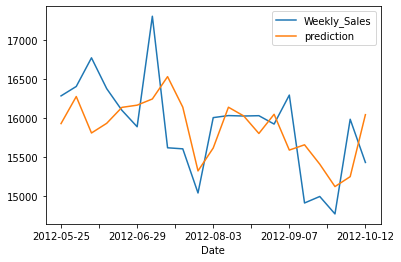

In [43]:
#normalized 후 vanila rnn

my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc)
pred_plot(rnn_predictions_2)

In [183]:
my_rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 5, 32)             1088      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3,234
Trainable params: 3,234
Non-trainable params: 0
_________________________________________________________________


LSTM

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 50)             10400     
                                                                 
 lstm_4 (LSTM)               (None, 5, 50)             20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 50,902
Trainable params: 50,902
Non-trainable params: 0
_________________________________________________________________
Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15596.002930
2012-06-01    15641.948242
Name: prediction, dtype: floa

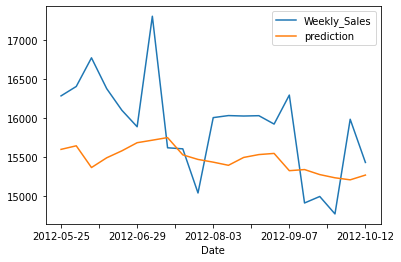

In [45]:
#LSTM (vanila rnn과 동일한 optimizer)
def LSTM_model(X_train, y_train, X_test, sc):

    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=500, verbose=0)
    my_LSTM_model.summary()

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction, my_LSTM_model.summary

my_LSTM_model, LSTM_prediction, my_LSTM_model.summary = LSTM_model(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction)


In [46]:
my_LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 50)             10400     
                                                                 
 lstm_4 (LSTM)               (None, 5, 50)             20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 50,902
Trainable params: 50,902
Non-trainable params: 0
_________________________________________________________________


Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15908.395508
2012-06-01    15909.216797
Name: prediction, dtype: float32
len comp(true vs pred): 21 21
mae: 464.9108 mse: 375980.1 AxesSubplot(0.125,0.125;0.775x0.755)


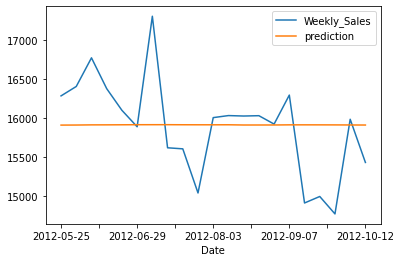

In [47]:
#LSTM (ref 코드 대로 ) -왜이래 미쳤네
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)
    

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
pred_plot(LSTM_prediction)

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15962.449219
2012-06-01    16108.078125
Name: prediction, dtype: float32
len comp(true vs pred): 21 21
mae: 472.42642 mse: 354319.03 AxesSubplot(0.125,0.125;0.775x0.755)


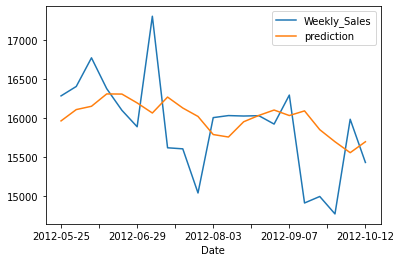

In [184]:
def LSTM_model_regularization(X_train, y_train, X_test, sc): #vanila rnn과 동일한 optimizer
    # create a model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM,Dropout
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dropout(0.2))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=500, verbose=0)


    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
pred_plot(LSTM_prediction)

In [185]:
my_LSTM_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 5, 50)             10400     
                                                                 
 lstm_31 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_26 (Dense)            (None, 2)                 102       
                                                                 
Total params: 30,702
Trainable params: 30,702
Non-trainable params: 0
_________________________________________________________________


GRU

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15608.726562
2012-06-01    15610.646484
Name: prediction, dtype: float32
len comp(true vs pred): 21 21
mae: 567.0007 mse: 460402.44 AxesSubplot(0.125,0.125;0.775x0.755)


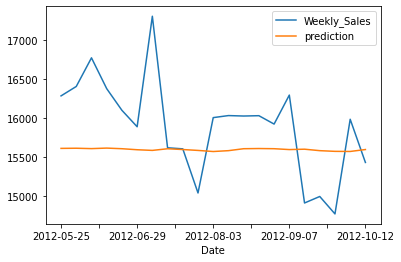

In [49]:
#GRU (노트 as is)
def GRU_model(X_train, y_train, X_test, sc):
    # create a model 
    from tensorflow.keras.models import Sequential 
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD 
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_absolute_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
pred_plot(GRU_prediction)

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15819.730469
2012-06-01    16203.443359
Name: prediction, dtype: float32
len comp(true vs pred): 21 21
mae: 414.6193 mse: 292474.8 AxesSubplot(0.125,0.125;0.775x0.755)


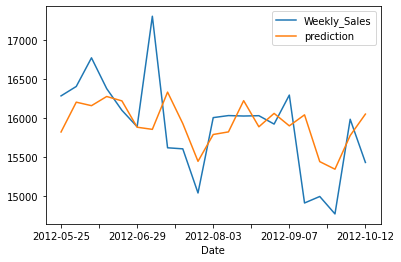

In [50]:
#GRU (vanila compile)
def GRU_model(X_train, y_train, X_test, sc):
    # create a model 
    from tensorflow.keras.models import Sequential 
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD 
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling
    my_GRU_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=500, verbose=0)
    # Compiling the RNN 
    #my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
    #                                     momentum = 0.9, nesterov = False), 
    #                     loss = 'mean_absolute_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
pred_plot(GRU_prediction)

In [186]:
my_GRU_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 5, 50)             7950      
                                                                 
 gru_3 (GRU)                 (None, 50)                15300     
                                                                 
 dense_7 (Dense)             (None, 2)                 102       
                                                                 
Total params: 23,352
Trainable params: 23,352
Non-trainable params: 0
_________________________________________________________________


주식 데이터 모델로 transfer learning 시도 







In [75]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [76]:
stock = fdr.DataReader(STOCK_CODE)
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

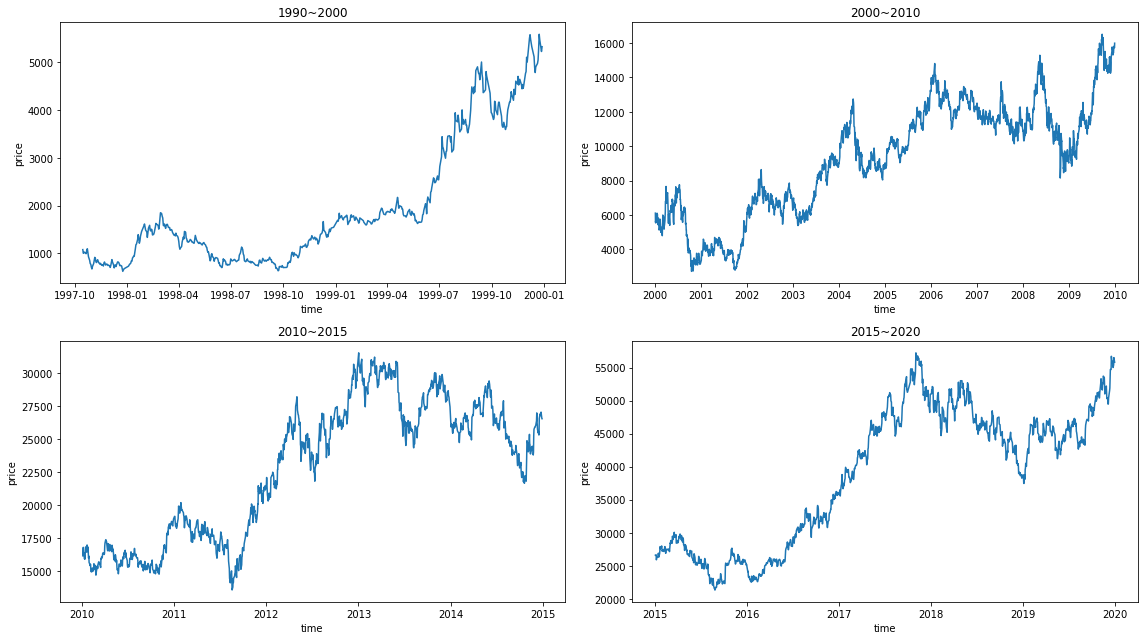

In [77]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [150]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
df2 = pd.DataFrame(scaled, columns=scale_cols)

In [221]:
df2.shape

(6000, 5)

In [79]:
# train, test분할
from sklearn.model_selection import train_test_split
X_train_s, X_test_2, y_train_s, y_test_s = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [80]:
#TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성
def windowed_dataset(series, window_size, batch_size, shuffle):
  """
    window size=3이면 3일 주가 보고, 다음날 예측
    stride - window를 한칸식 건너 뛰면서 묶겠다. 
    drop_remainder - window생성시 남는 데이터를 어떻게 처리할지 -> 크기 일치시키기 위해 true로 설정
    shuffle(buffer_size)데이터 셋 섞기 ,30000개 데이터에서 버퍼사이즈가 1000이라면 0~999인덱스 사이즈 중 랜덤 추출
    prefetch -미리 데이터를 fetch. (병렬 처리 하기 때문에 학습 속도 개선)
    prefetch(1)시 다음 데이터 만들어, 1번 학습 시  병렬 적으로 뒤에 배치를 만듬 , 미리 만들어서 바로 학습
    """
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series) # numpy array(series)를 넣으면 data set class 로 변경,  dataset이 구현가능한 함수 사용 위해
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True) #window set을 짜를 때는 size , size+1 (y)까지 자름
    
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  if shuffle:
      ds = ds.shuffle(1000)
  ds = ds.map(lambda w: (w[:-1], w[-1])) #(x(window 사이즈 개수),y)
  return ds.batch(batch_size).prefetch(1)

In [81]:
#hyper parameter - 5일치 학습
WINDOW_SIZE=5
BATCH_SIZE=32

In [125]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 
train_data_s = windowed_dataset(y_train_s, WINDOW_SIZE, BATCH_SIZE, False)
test_data_s = windowed_dataset(y_test_s, WINDOW_SIZE, BATCH_SIZE, False)

In [83]:
# 데이터 셋 잘 구성 됐는지 확인
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1): #take 1- 한 개의 batch 만
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 5, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [ ]:
#삼성전자 시계열 예측 original 
 model = Sequential([
#     1차원 feature map 생성
     Conv1D(filters=32, kernel_size=5,
            padding="causal",
            activation="relu",input_shape=[WINDOW_SIZE, 1]),
     Dense(16, activation="relu"),
#     LSTM
     Dense(16, activation="relu"),
     LSTM(16, activation='tanh'),
     Dense(16, activation="relu"),
     Dense(1),
 ])
 # Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.01)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

model.summary()

In [211]:
#내 LSTM과 층동일하게 
model = Sequential([

LSTM(50, activation='tanh',return_sequences=True),
LSTM(50, activation='tanh',return_sequences=True),     
LSTM(50, activation='tanh'),
Dense(2)])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.01)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

history = model.fit(train_data_s, 
                    validation_data=(test_data_s), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    149/Unknown - 8s 9ms/step - loss: 1.5684e-04 - mse: 3.1368e-04
Epoch 00001: val_loss improved from inf to 0.00710, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 10s 20ms/step - loss: 1.5726e-04 - mse: 3.1452e-04 - val_loss: 0.0071 - val_mse: 0.0142
Epoch 2/50
145/150 [============================>.] - ETA: 0s - loss: 3.3137e-05 - mse: 6.6275e-05
Epoch 00002: val_loss improved from 0.00710 to 0.00523, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 2s 11ms/step - loss: 3.4187e-05 - mse: 6.8373e-05 - val_loss: 0.0052 - val_mse: 0.0105
Epoch 3/50
145/150 [============================>.] - ETA: 0s - loss: 2.3673e-05 - mse: 4.7346e-05
Epoch 00003: val_loss improved from 0.00523 to 0.00343, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 2s 11ms/step - loss: 2.3876e-05 - mse: 4.7752e-05 - val_loss: 0.0034 - val_mse: 0.0069
Epoch 4/50
148/150 [============================>.] - E

In [212]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, None, 50)          10400     
                                                                 
 lstm_48 (LSTM)              (None, None, 50)          20200     
                                                                 
 lstm_49 (LSTM)              (None, 50)                20200     
                                                                 
 dense_30 (Dense)            (None, 2)                 102       
                                                                 
Total params: 50,902
Trainable params: 50,902
Non-trainable params: 0
_________________________________________________________________


In [123]:
#시각화

#지표
  mae=MeanAbsoluteError()
  mse=MeanSquaredError()
  result=mae(y_test[5:],pred).numpy()
  result2=mse(y_test[5:],pred).numpy()

#그래프
  plt.figure(figsize=(12, 9))
  plt.plot(np.asarray(y_test)[5:], label='actual')
  plt.plot(pred, label='prediction')
  plt.legend()
  plt.show()
  
    

In [213]:
#model save
if os.path.isfile('models/stock_model.h5') is False:
  model.save('models/stock_model.h5')

In [220]:
model.get_weights()

[array([[-1.15316316e-01, -2.40251683e-02, -3.91446277e-02,
          1.68633666e-02, -1.52615547e-01,  7.29100481e-02,
          7.91328251e-02,  2.84460962e-01,  4.50615138e-02,
          2.16433853e-02, -2.44730413e-01,  1.67624295e-01,
         -1.66283533e-01,  1.70810983e-01,  3.01183574e-02,
          2.61153370e-01,  8.88536125e-02, -8.25159103e-02,
          4.20327820e-02, -2.53019612e-02,  2.66833063e-02,
         -8.31610337e-02,  1.62537396e-02,  5.13624437e-02,
         -4.57376167e-02, -2.14965194e-01, -1.03287585e-01,
          1.00683257e-01, -6.53759092e-02, -3.20254937e-02,
          1.65902838e-01, -2.06802636e-01, -6.12048171e-02,
          5.12830094e-02, -5.14814928e-02,  9.65516865e-02,
         -8.44944790e-02, -2.17532456e-01, -4.82732207e-02,
         -1.05535977e-01, -1.67434185e-03,  4.52401340e-02,
         -9.16240960e-02,  3.94642120e-05,  1.57676246e-02,
          7.66072720e-02,  3.55211161e-02, -1.32698998e-01,
          3.80492362e-04,  7.38477707e-0

In [88]:
from tensorflow.keras.models import Sequential, load_model

In [214]:
my_LSTM_model=load_model('models/stock_model.h5')

In [215]:
my_LSTM_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, None, 50)          10400     
                                                                 
 lstm_12 (LSTM)              (None, None, 50)          20200     
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 2)                 102       
                                                                 
Total params: 50,902
Trainable params: 50,902
Non-trainable params: 0
_________________________________________________________________


In [113]:
len(my_LSTM_model.layers)

4

In [216]:
X_train.shape

(114, 5, 1)

Epoch 1/500
4/4 [==============================] - 5s 9ms/step - loss: 0.0911
Epoch 2/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0859
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0827
Epoch 4/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0802
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0785
Epoch 6/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0763
Epoch 7/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0752
Epoch 8/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0743
Epoch 9/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0738
Epoch 10/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0725
Epoch 11/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0724
Epoch 12/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0714
Epoch 13/500
4/4 [==============================] - 0s 9m

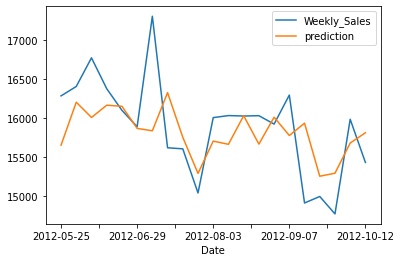

In [217]:
#LSTM에 적용 (마지막 레이어만 학습)

#LSTM (vanila rnn과 동일한 optimizer)
def LSTM_model(X_train, y_train, X_test, sc):

    my_LSTM_model=load_model('models/stock_model.h5')
    # The LSTM architecture
    # my_LSTM_model = Sequential()
    # my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    # #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    # my_LSTM_model.add(Dense(units=2))

    #my_LSTM_model.load_weights(stock_weight)

    for layer in my_LSTM_model.layers[:-1]:
      layer.trainbale=False

    # Compiling
    my_LSTM_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=500, verbose=1)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction= LSTM_model(X_train,y_train,X_test,sc)
pred_plot(LSTM_prediction)


In [218]:
my_LSTM_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, None, 50)          10400     
                                                                 
 lstm_12 (LSTM)              (None, None, 50)          20200     
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 2)                 102       
                                                                 
Total params: 50,902
Trainable params: 50,902
Non-trainable params: 0
_________________________________________________________________


In [219]:
my_LSTM_model.get_weights()

[array([[ 0.00301329,  0.154186  ,  0.07248038,  0.16738755,  0.11062931,
          0.19588195,  0.14623609,  0.05914765,  0.23131855, -0.05617389,
          0.2982492 ,  0.10504344,  0.04263344,  0.2887079 ,  0.07075435,
          0.14904049,  0.02007978,  0.14049499,  0.0338082 , -0.0520284 ,
         -0.0840233 ,  0.12148624,  0.18406968, -0.08523374,  0.25675267,
          0.40195945,  0.22530878,  0.21820104, -0.04823295,  0.2443122 ,
          0.16590232,  0.17202106,  0.11420447,  0.18815044, -0.06724623,
          0.08537538,  0.1372424 , -0.01701912,  0.10986061,  0.20923282,
         -0.06726706,  0.18333152,  0.0401561 ,  0.10903406,  0.21971495,
          0.05410012, -0.15187673,  0.1146351 ,  0.03411605,  0.08601724,
          0.3682693 ,  0.22770794,  0.20503806,  0.45274454, -0.00150553,
          0.18814024,  0.11226508,  0.08635798,  0.13647588,  0.02477347,
          0.05649688, -0.15722954, -0.10922751,  0.43980333,  0.17688684,
          0.14318284,  0.44601998,  0.

Epoch 1/500
4/4 [==============================] - 5s 10ms/step - loss: 0.0921
Epoch 2/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0851
Epoch 3/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0829
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0799
Epoch 5/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0784
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0768
Epoch 7/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0758
Epoch 8/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0746
Epoch 9/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0738
Epoch 10/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0732
Epoch 11/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0729
Epoch 12/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0719
Epoch 13/500
4/4 [==============================] - 0s 9m

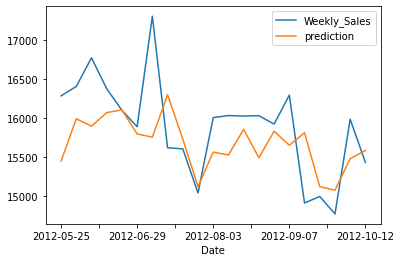

In [143]:
#LSTM BEST MODEL (마지막 2층 학습)

#LSTM (vanila rnn과 동일한 optimizer)
def LSTM_model(X_train, y_train, X_test, sc):

    my_LSTM_model=load_model('models/stock_model.h5')


    for layer in my_LSTM_model.layers[:-2]:
      layer.trainbale=False

    # Compiling
    my_LSTM_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=500, verbose=1)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction= LSTM_model(X_train,y_train,X_test,sc)
pred_plot(LSTM_prediction)

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15614.916016
2012-06-01    15760.833008
Name: prediction, dtype: float32
len comp(true vs pred): 21 21
mae: 518.87354 mse: 382753.88 AxesSubplot(0.125,0.125;0.775x0.755)


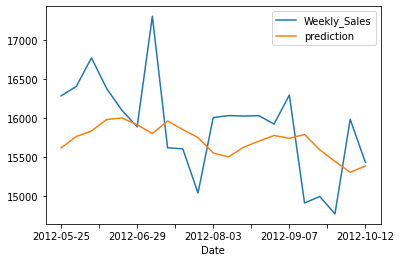

In [116]:
#LSTM BEST MODEL (마지막 3층 학습)

#LSTM (vanila rnn과 동일한 optimizer)
def LSTM_model(X_train, y_train, X_test, sc):

    my_LSTM_model=load_model('models/stock_model.h5')


    for layer in my_LSTM_model.layers[:-3]:
      layer.trainbale=False

    # Compiling
    my_LSTM_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=500, verbose=1)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction
my_LSTM_model, LSTM_prediction= LSTM_model(X_train,y_train,X_test,sc)
pred_plot(LSTM_prediction)

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15694.261719
2012-06-01    15754.420898
Name: prediction, dtype: float32
len comp(true vs pred): 21 21
mae: 510.0207 mse: 374921.72 AxesSubplot(0.125,0.125;0.775x0.755)


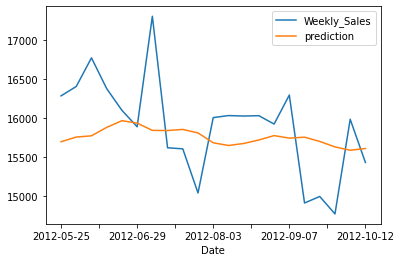

In [153]:
def LSTM_model_regularization(X_train, y_train, X_test, sc): #vanila rnn과 동일한 optimizer
  from tensorflow.keras.layers import Dropout
  my_LSTM_model=load_model('models/stock_model.h5')


  for layer in my_LSTM_model.layers[:-2]:
    layer.trainbale=False

    # The LSTM architecture
  my_LSTM_model = Sequential()
  my_LSTM_model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
  my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
  my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
  my_LSTM_model.add(LSTM(units=50, activation='tanh'))
  my_LSTM_model.add(Dropout(0.2))
  my_LSTM_model.add(Dense(units=2))

    # Compiling
  my_LSTM_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
  my_LSTM_model.fit(X_train,y_train,epochs=500, verbose=0)


  LSTM_prediction = my_LSTM_model.predict(X_test)
  LSTM_prediction = sc.inverse_transform(LSTM_prediction)

  return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
pred_plot(LSTM_prediction)

In [154]:
my_LSTM_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 5, 50)             10400     
                                                                 
 lstm_26 (LSTM)              (None, 5, 50)             20200     
                                                                 
 lstm_27 (LSTM)              (None, 5, 50)             20200     
                                                                 
 lstm_28 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_22 (Dense)            (None, 2)                 102       
                                                                 
Total params: 71,102
Trainable params: 71,102
Non-tra

In [241]:
##stock original

model = Sequential([
#      1차원 feature map 생성
     Conv1D(filters=32, kernel_size=5,
            padding="causal",
            activation="relu",input_shape=[WINDOW_SIZE, 1]),
#LSTM(50, activation='tanh',return_sequences=True),
#LSTM(50, activation='tanh',return_sequences=True),     
#LSTM(50, activation='tanh'),
#Dense(2)])
#     LSTM
     Dense(16, activation="relu"),
     LSTM(16, activation='tanh'),
     Dense(16, activation="relu"),
     Dense(1),
 ])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.01)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

history = model.fit(train_data_s, 
                    validation_data=(test_data_s), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    144/Unknown - 4s 7ms/step - loss: 6.6138e-05 - mse: 1.3228e-04
Epoch 00001: val_loss improved from inf to 0.00069, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 5s 13ms/step - loss: 6.4791e-05 - mse: 1.2958e-04 - val_loss: 6.8597e-04 - val_mse: 0.0014
Epoch 2/50
143/150 [===========================>..] - ETA: 0s - loss: 1.9473e-05 - mse: 3.8946e-05
Epoch 00002: val_loss improved from 0.00069 to 0.00057, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 1s 9ms/step - loss: 2.1458e-05 - mse: 4.2915e-05 - val_loss: 5.6540e-04 - val_mse: 0.0011
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 1.7495e-05 - mse: 3.4989e-05
Epoch 00003: val_loss did not improve from 0.00057
150/150 [==============================] - 1s 8ms/step - loss: 1.7495e-05 - mse: 3.4989e-05 - val_loss: 6.0141e-04 - val_mse: 0.0012
Epoch 4/50
148/150 [============================>.] - ETA: 0s - loss: 2.7355e-05 - mse: 5

In [156]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 5, 32)             192       
                                                                 
 dense_23 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_29 (LSTM)              (None, 16)                2112      
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


mae: 15694.81 mse 246678500.0


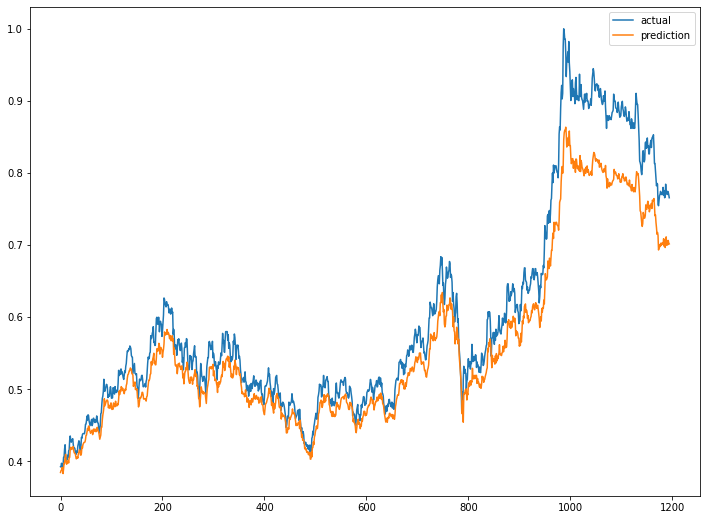

In [224]:
pred= model.predict(test_data_s)
#지표
mae=MeanAbsoluteError()
mse=MeanSquaredError()
result=mae(y_test[5:],pred).numpy()
result2=mse(y_test[5:],pred).numpy()
print("mae:",result,"mse",result2)

#그래프
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test_s)[5:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [226]:
if os.path.isfile('models/stock_model.h5') is False:
  model.save('models/stock_model2.h5')

In [227]:
my_LSTM_model=load_model('models/stock_model2.h5')

In [228]:
my_LSTM_model.trainable=False
my_LSTM_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 5, 32)             192       
                                                                 
 dense_23 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_29 (LSTM)              (None, 16)                2112      
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 0
Non-trainable params: 3,121
_________________________________________________________________


Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15650.165039
2012-06-01    16202.963867
Name: prediction, dtype: float32
len comp(true vs pred): 21 21
mae: 410.73657 mse: 291458.16 AxesSubplot(0.125,0.125;0.775x0.755)


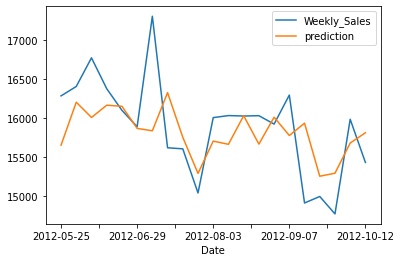

In [229]:
#LSTM BEST MODEL

#LSTM (vanila rnn과 동일한 optimizer)
def new_model_fun(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model2.h5')
    # The LSTM architecture
    # my_LSTM_model = Sequential()
    # my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    # #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    # my_LSTM_model.add(Dense(units=2))

    #my_LSTM_model.load_weights(stock_weight)

    new_model.trainable=False
    
    # Compiling
    new_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=0)

    LSTM_prediction = new_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return new_model, LSTM_prediction

new_model_fun(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction)

In [232]:
new_model

<function __main__.new_model>

In [192]:
for layer in new_model.layers:
  print(layer)

In [222]:
my_LSTM_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, None, 50)          10400     
                                                                 
 lstm_12 (LSTM)              (None, None, 50)          20200     
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 2)                 102       
                                                                 
Total params: 50,902
Trainable params: 50,902
Non-trainable params: 0
_________________________________________________________________


Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15737.154297
2012-06-01    15979.203125
Name: prediction, dtype: float32
len comp(true vs pred): 21 21
mae: 522.2025 mse: 402935.2 AxesSubplot(0.125,0.125;0.775x0.755)


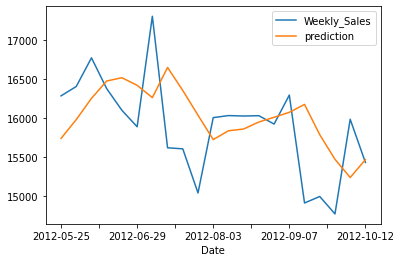

In [233]:
new_model=load_model('models/stock_model2.h5')
    # The LSTM architecture
    # my_LSTM_model = Sequential()
    # my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    # #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    # my_LSTM_model.add(Dense(units=2))

    #my_LSTM_model.load_weights(stock_weight)

new_model.trainable=False
    
    # Compiling
new_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
new_model.fit(X_train,y_train,epochs=500, verbose=0)

LSTM_prediction = new_model.predict(X_test)
LSTM_prediction = sc.inverse_transform(LSTM_prediction)

pred_plot(LSTM_prediction)

In [234]:
new_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 5, 32)             192       
                                                                 
 dense_23 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_29 (LSTM)              (None, 16)                2112      
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 0
Non-trainable params: 3,121
_________________________________________________________________


In [238]:
X_train.shape

(114, 5, 1)

Epoch 1/500
4/4 [==============================] - 5s 9ms/step - loss: 0.0902
Epoch 2/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0840
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0813
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0793
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0776
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0763
Epoch 7/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0752
Epoch 8/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0741
Epoch 9/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0733
Epoch 10/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0724
Epoch 11/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0720
Epoch 12/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0715
Epoch 13/500
4/4 [==============================] - 0s 9ms/

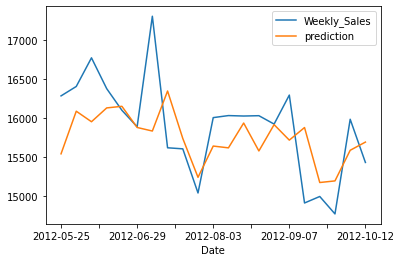

In [239]:
#LSTM BEST MODEL (마지막 층 학습 )

new_model=load_model('models/stock_model2.h5')

for layer in new_model.layers[:-1]:
  layer.trainbale=False

    # Compiling
new_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
new_model.fit(X_train,y_train,epochs=500, verbose=0)

LSTM_prediction = new_model.predict(X_test)
LSTM_prediction = sc.inverse_transform(LSTM_prediction)

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction)

In [240]:
new_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 5, 32)             192       
                                                                 
 dense_23 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_29 (LSTM)              (None, 16)                2112      
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
4/4 [==============================] - 6s 11ms/step - loss: 0.0919
Epoch 2/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0858
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0830
Epoch 4/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0805
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0785
Epoch 6/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0771
Epoch 7/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0758
Epoch 8/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0746
Epoch 9/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0738
Epoch 10/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0731
Epoch 11/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0722
Epoch 12/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0717
Epoch 13/500
4/4 [==============================] - 0s 1

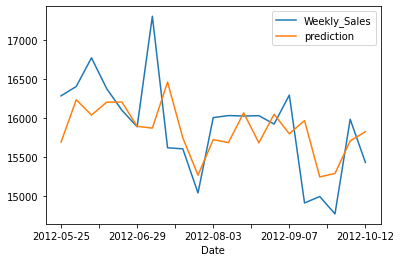

In [235]:
#LSTM BEST MODEL (두 층 학습 )

new_model=load_model('models/stock_model2.h5')

for layer in new_model.layers[:-2]:
  layer.trainbale=False

    # Compiling
new_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
new_model.fit(X_train,y_train,epochs=500, verbose=0)

LSTM_prediction = new_model.predict(X_test)
LSTM_prediction = sc.inverse_transform(LSTM_prediction)

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction)

In [236]:
new_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 5, 32)             192       
                                                                 
 dense_23 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_29 (LSTM)              (None, 16)                2112      
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


In [242]:
new_model.layers[1]

Epoch 1/500
4/4 [==============================] - 5s 9ms/step - loss: 0.0911
Epoch 2/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0853
Epoch 3/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0823
Epoch 4/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0796
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0777
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0764
Epoch 7/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0751
Epoch 8/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0743
Epoch 9/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0735
Epoch 10/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0728
Epoch 11/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0719
Epoch 12/500
4/4 [==============================] - 0s 9ms/step - loss: 0.0717
Epoch 13/500
4/4 [==============================] - 0s 10ms/

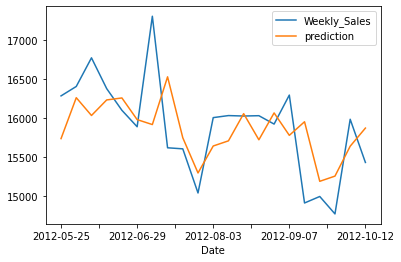

In [243]:
#LSTM BEST MODEL (한 층 학습 )

new_model=load_model('models/stock_model2.h5')
new_model.trainable=False

new_model.layers[4].trainable=True

    # Compiling
new_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
new_model.fit(X_train,y_train,epochs=500, verbose=0)

LSTM_prediction = new_model.predict(X_test)
LSTM_prediction = sc.inverse_transform(LSTM_prediction)

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction)

In [245]:
new_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 5, 32)             192       
                                                                 
 dense_23 (Dense)            (None, 5, 16)             528       
                                                                 
 lstm_29 (LSTM)              (None, 16)                2112      
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,121
Trainable params: 0
Non-trainable params: 3,121
_________________________________________________________________


 결론
 

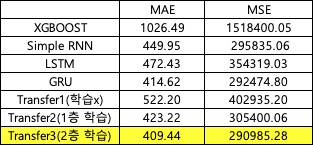